<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Fast Food Chains and Price Discrimination

_Authors: Kiefer Katovich (SF), Mario Carrillo (SF)_

---

This group lab uses a 1994 data set of detailed prices on items sold at more than 400 Burger King, Wendy's, KFC, and [Roy Rogers](https://en.wikipedia.org/wiki/Roy_Rogers_Restaurants) restaurants in New Jersey and Pennsylvania.

The data set is a restricted version of the data set used in this publication:

> [K. Graddy (1997), "Do Fast-Food Chains Price Discriminate on the Race and Income Characteristics of an Area?" Journal of Business and Economic Statistics 15, 391-401](http://people.brandeis.edu/~kgraddy/published%20papers/GraddyK_jbes1997.pdf).

**The goal of this exercise is to evaluate whether or not fast food restaurants are using discriminatory pricing.** This is a fairly open-ended prompt. It's up to you to determine how to quantify pricing discrimination using the following groups of variables:
- The price of fast food items, which can be a metric of discriminatory practices.
- The proportion of African Americans residents, low-income residents, and residents without a car.

---

### In Groups, You Should:

1) **Load and examine the data.**

2) **Perform any necessary data cleaning.**

3) **Conduct an exploratory data analysis relevant to the goals of the project.** What variables are you interested in for your target(s) and predictors? What types of relationships do you see in the data that will inform your analysis?
prpblck       proportion black, zipcode
prppov        proportion in poverty, zipcode
prpncar       proportion no car, zipcode

4) **Formulate and formally define your hypotheses.** Based on the prompt and your EDA, come up with a plan for testing each one.


5) **Construct regression models to test each hypothesis.** What are your findings? Do they support the hypothesis? What are the limitations and assumptions of your approach? 

6) **[Bonus] Cross-validate the results of your regression.** If the results support your hypotheses, do they hold up during cross-validation or a train/test split?

7) **Prepare a brief (10-minute) presentation on the findings.** Each group's presentation should include your questions, models, and findings.
    - Be concise! Only include relevant information in your presentation.
    - Visuals are nice, but don't overdo it.
    - Don't just talk about your model's significance or metrics. Interpret the coefficients. What are the implications?
    - What future hypotheses could you test going forward?


> *Note*: If you are interested, the full data set is also available in the "datasets" folder under the name `discrim_full.csv`.

### Data Set Characteristics

    :Number of Instances: 410
    
    :Attribute Information
    
    psoda         price of medium soda
    pfries        price of small fries
    pentree       price entree (burger or chicken)
    wagest        starting wage
    nmgrs         number of managers
    nregs         number of registers
    hrsopen       hours open
    emp           number of employees
    compown       =1 if company owned
    chain         BK = 1, KFC = 2, Roy Rogers = 3, Wendy's = 4
    density       population density, town
    crmrte        crime rate, town
    state         NJ = 1, PA = 2
    prpblck       proportion black, zipcode
    prppov        proportion in poverty, zipcode
    prpncar       proportion no car, zipcode
    hseval        median housing value, zipcode
    nstores       number of stores, zipcode
    income        median family income, zipcode
    county        county label
    NJ            =1 for New Jersey
    BK            =1 if Burger King
    KFC           =1 if Kentucky Fried Chicken
    RR            =1 if Roy Rogers

In [145]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/regressions packages
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score

# Make sure your charts appear in the notebook
%matplotlib inline
%config InlineBackend.figure_format ='retina'

C:\Users\ngyen\Anaconda2python2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
food = pd.read_csv('./datasets/discrim.csv')

In [3]:
food.head()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,prppov,prpncar,hseval,nstores,income,county,NJ,BK,KFC,RR
0,1.12,1.06,1.02,4.25,3.0,5.0,16.0,27.5,1,3,...,0.036579,0.078843,148300.0,3,44534.0,18,1,0,0,1
1,1.06,0.91,0.95,4.75,3.0,3.0,16.5,21.5,0,1,...,0.036579,0.078843,148300.0,3,44534.0,18,1,1,0,0
2,1.06,0.91,0.98,4.25,3.0,5.0,18.0,30.0,0,1,...,0.087907,0.269430,169200.0,3,41164.0,12,1,1,0,0
3,1.12,1.02,1.06,5.00,4.0,5.0,16.0,27.5,0,3,...,0.059123,0.136690,171600.0,3,50366.0,10,1,0,0,1
4,1.12,NaN,0.49,5.00,3.0,3.0,16.0,5.0,0,1,...,0.025414,0.073802,249100.0,1,72287.0,10,1,1,0,0


# Clean data 

In [4]:
food.isnull().sum()

psoda       8
pfries     17
pentree    12
wagest     20
nmgrs       6
nregs      22
hrsopen     0
emp         6
compown     0
chain       0
density     1
crmrte      1
state       0
prpblck     1
prppov      1
prpncar     1
hseval      1
nstores     0
income      1
county      0
NJ          0
BK          0
KFC         0
RR          0
dtype: int64

In [5]:
food.shape

(410, 24)

In [6]:
food['state'].value_counts()

1    331
2     79
Name: state, dtype: int64

In [7]:
# Only drop data of features we are concerned with 
food_used = food.dropna(axis=0, how='any', subset=['psoda', 'pfries', 'pentree','income','density'])

In [8]:
# After cleaning, we have this: 
food_used.shape

(385, 24)

In [10]:
# create a new column where pmeal = psoda + pfries + pentree --> this is our target price 
food_used['pmeal'] = food_used['psoda'] + food_used['pfries'] + food_used['pentree']

C:\Users\ngyen\Anaconda2python2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [176]:
# to create copy for standby haha. 
df = food_used.copy()

In [177]:
# Thought that the number of these features may show a clearer picture
for i in ['prpblck','prppov','prpncar']:
    df[i+'_count'] = df[i]*df['density']

In [184]:
df['scaled_income'] = StandardScaler().fit_transform(df[['income']].values)

In [185]:
df['scaled_pmeal'] = StandardScaler().fit_transform(df[['pmeal']].values)

In [186]:
df.describe()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,NJ,BK,KFC,RR,pmeal,prpblck_count,prppov_count,prpncar_count,scaled_income,scaled_pmeal
count,385.000000,385.000000,385.000000,367.000000,379.000000,366.000000,385.000000,379.000000,385.000000,385.000000,...,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,3.850000e+02,3.850000e+02
mean,1.044000,0.921195,1.322909,4.615041,3.411082,3.584699,14.338961,17.306069,0.337662,2.109091,...,0.805195,0.420779,0.202597,0.223377,3.288104,930.432118,510.713242,935.388044,-1.470685e-16,-4.622565e-16
std,0.087474,0.105345,0.643223,0.347371,1.025203,1.239614,2.708982,8.752739,0.473528,1.117356,...,0.396566,0.494327,0.402458,0.417051,0.645133,2488.582840,1032.757247,2060.377928,1.001301e+00,1.001301e+00
min,0.730000,0.670000,0.520000,4.250000,1.000000,1.000000,7.000000,3.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.280000,0.000000,5.494527,0.000000,-2.341854e+00,-1.564662e+00
25%,0.980000,0.850000,0.950000,4.250000,3.000000,3.000000,12.000000,11.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,2.860000,31.422930,53.258520,78.462717,-7.023624e-01,-6.644532e-01
50%,1.060000,0.920000,1.020000,4.500000,3.000000,3.000000,15.000000,16.000000,0.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,3.040000,127.556532,145.668178,207.277743,-4.523332e-02,-3.850781e-01
75%,1.070000,1.000000,1.380000,4.975000,4.000000,4.000000,16.000000,20.750000,1.000000,3.000000,...,1.000000,1.000000,0.000000,0.000000,3.480000,431.640729,356.668808,568.855057,5.601884e-01,2.978388e-01
max,1.490000,1.270000,3.950000,5.750000,10.000000,8.000000,24.000000,67.500000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,5.860000,16936.375889,6948.848158,16403.665190,6.789060e+00,3.991798e+00


In [189]:
df.columns

Index([u'psoda', u'pfries', u'pentree', u'wagest', u'nmgrs', u'nregs',
       u'hrsopen', u'emp', u'compown', u'chain', u'density', u'crmrte',
       u'state', u'prpblck', u'prppov', u'prpncar', u'hseval', u'nstores',
       u'income', u'county', u'NJ', u'BK', u'KFC', u'RR', u'pmeal',
       u'prpblck_count', u'prppov_count', u'prpncar_count', u'scaled_income',
       u'scaled_pmeal'],
      dtype='object')

# EDA - Visually

In [179]:
# Features that we want to see 
features =  ['density',
             'prpblck',
             'prppov',
             'prpncar',
             'crmrte',
             'NJ',
             'county',
             'hseval',
             'nstores',
             'income',
             'hrsopen',
             'chain',
             'BK',
             'KFC',
             'RR',
             'prpblck_count',
             'prppov_count',
             'prpncar_count']

In [181]:
# predictors that we are interested in 
featuresp = ['density',
             'prpblck',
             'prppov',
             'prpncar',
             'crmrte',
             'NJ',
             'county',
             'hseval',
             'hrsopen',
             'nstores',
             'income',
             'prpblck_count',
             'prppov_count',
             'prpncar_count']

### EDA to try and find a relationship between 2 variables --> but it failed 
Read to see thought process, skip to [here](#here)

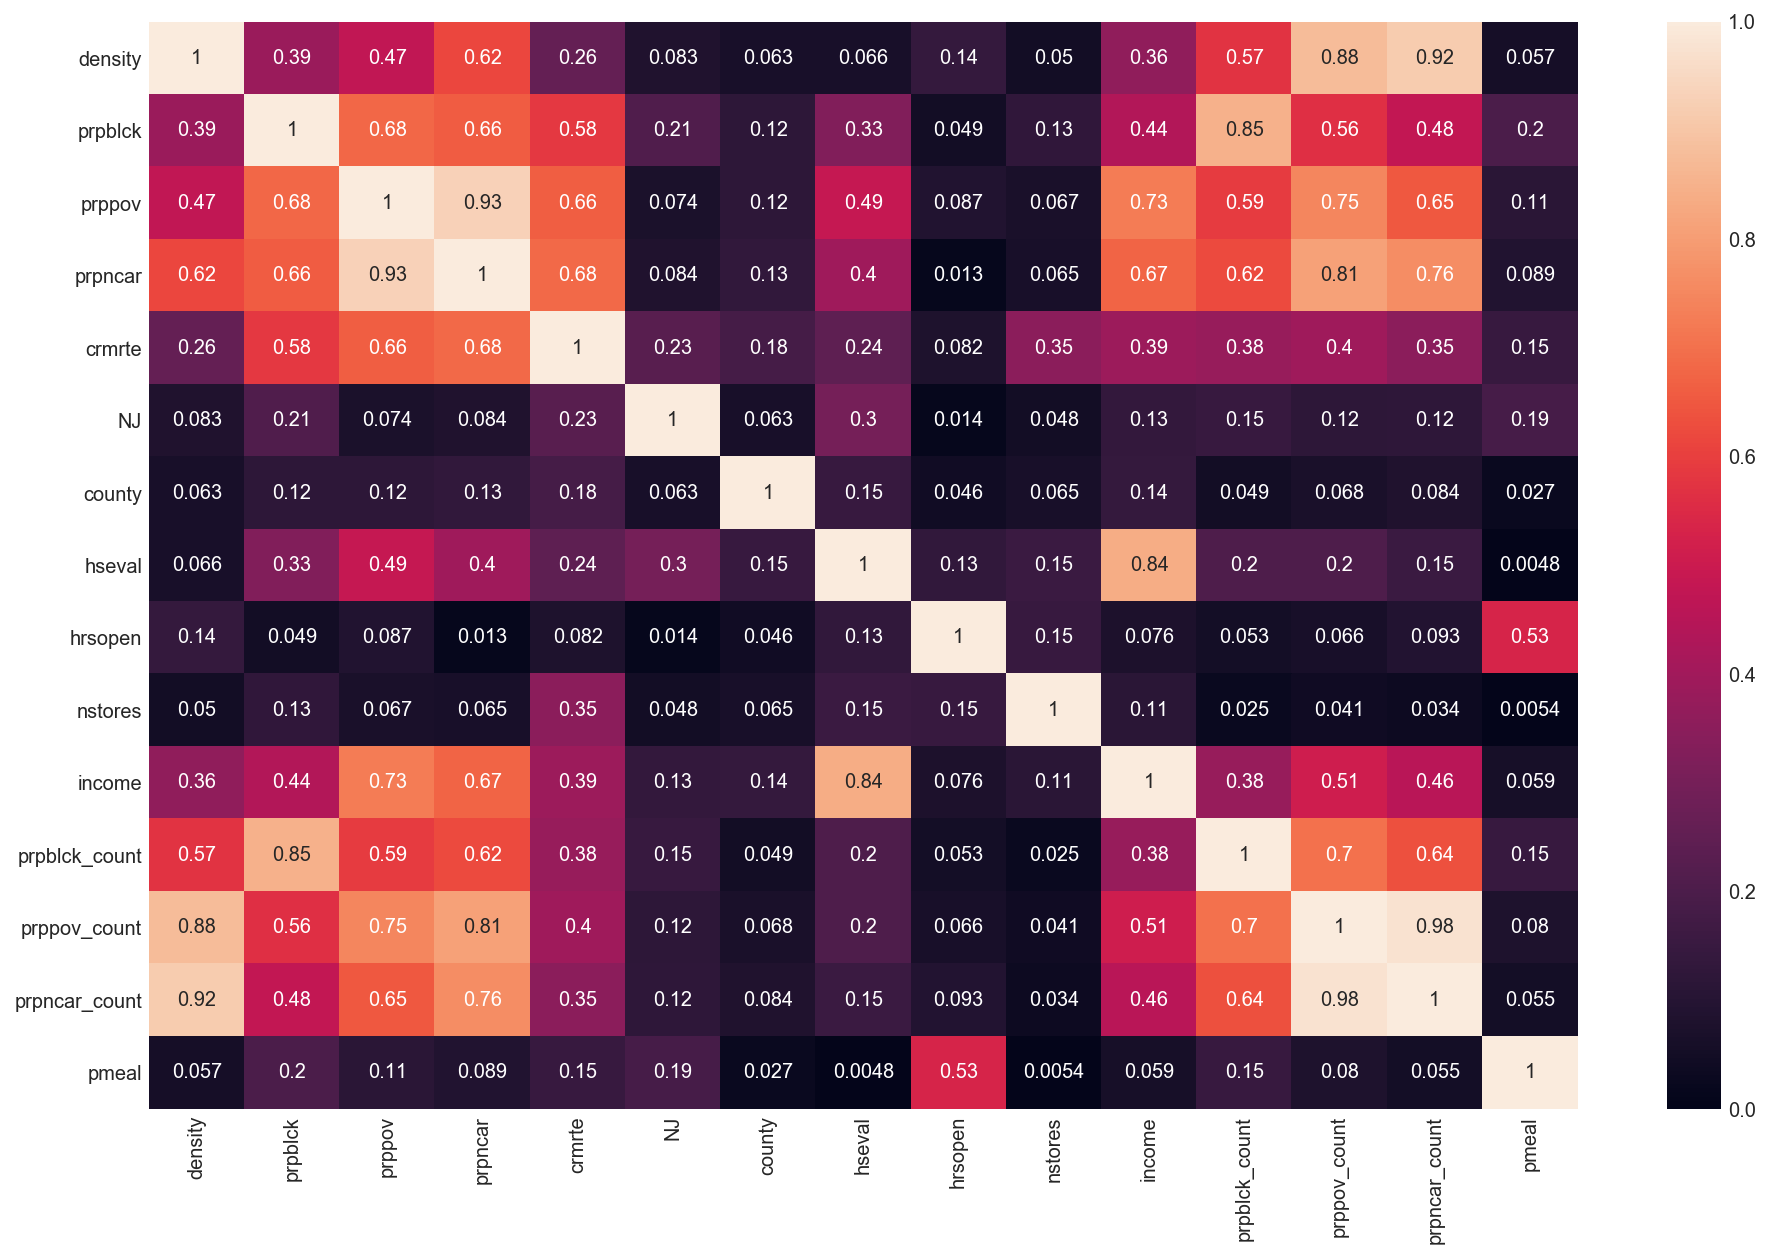

In [196]:
# To see co-linear relationship 
plt.figure(figsize=(16,10))
sns.heatmap(abs(df[featuresp + ['pmeal']].corr()),annot=True,vmin=0,vmax=1);

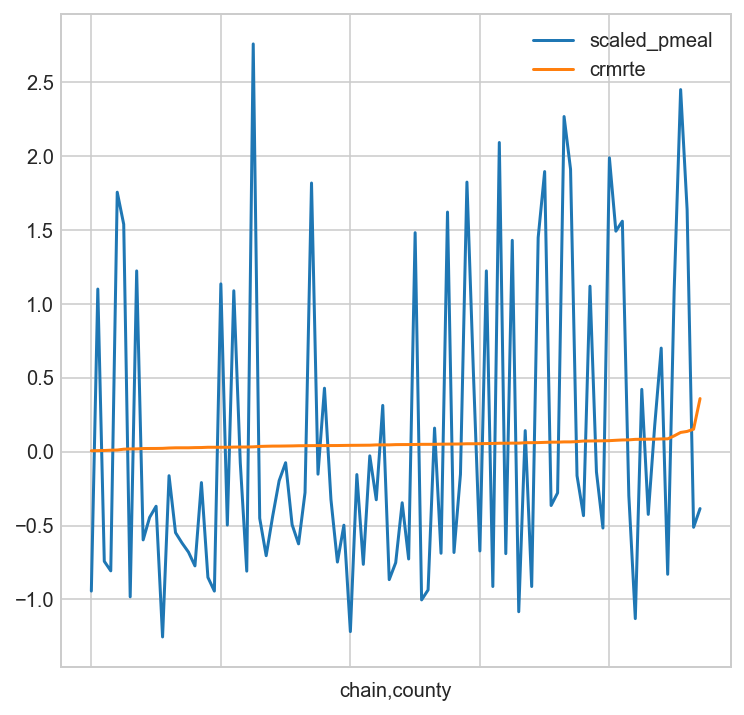

In [190]:
# Tried to group by county to see the mean of pmeal vs cmrte --> nope 
plt.figure()
df.groupby(['chain','county']).mean()[['scaled_pmeal','crmrte']].sort_values('crmrte').plot(figsize=(6,6));

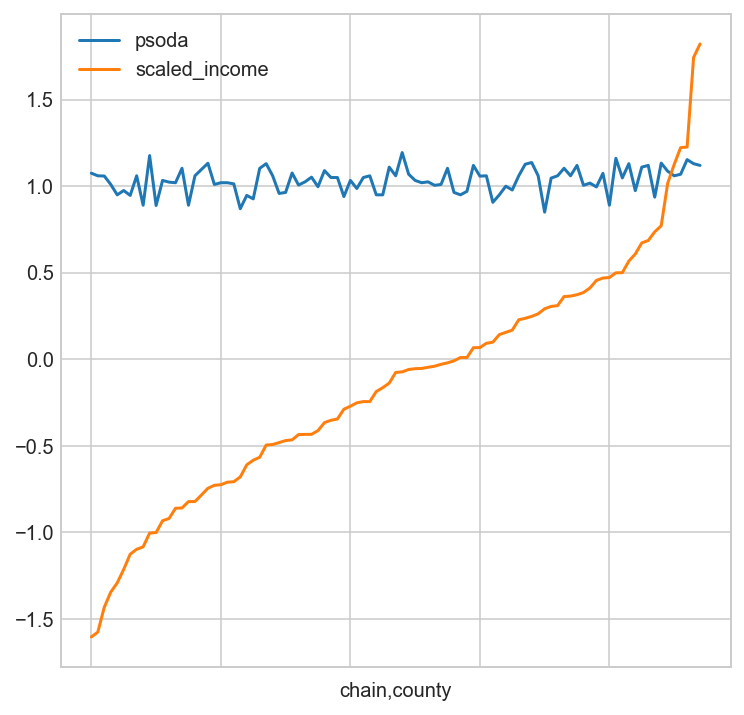

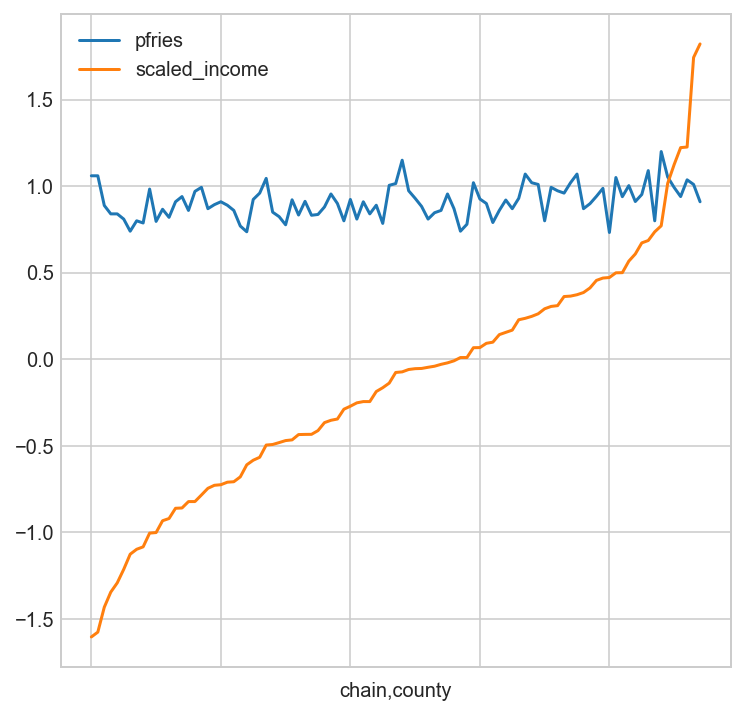

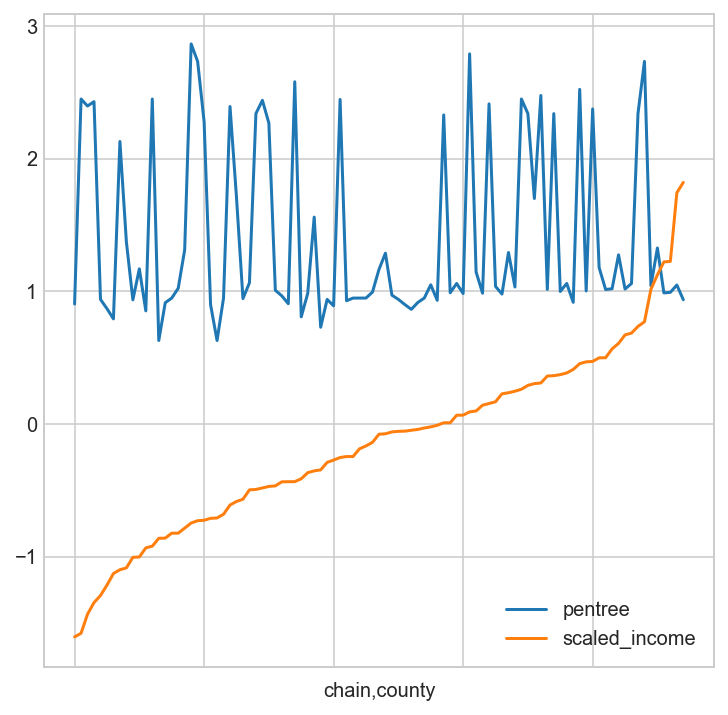

In [191]:
# Tried to see if each item's price affect income --> nope 
for i in ['psoda', 'pfries', 'pentree']:
    plt.figure()
    df.groupby(['chain','county']).mean()[[i,'scaled_income']].sort_values('scaled_income').plot(figsize=(6,6))

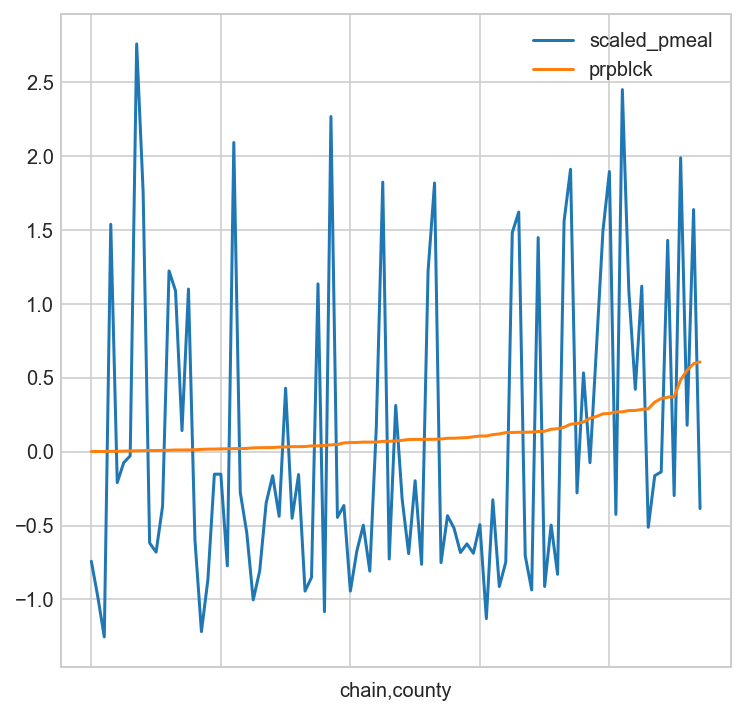

In [197]:
plt.figure()
df.groupby(['chain','county']).mean()[['scaled_pmeal','prpblck']].sort_values('prpblck').plot(figsize=(6,6))

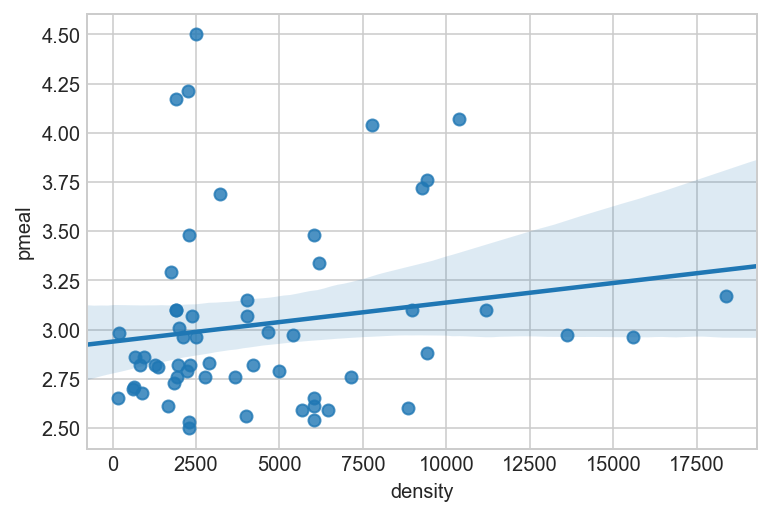

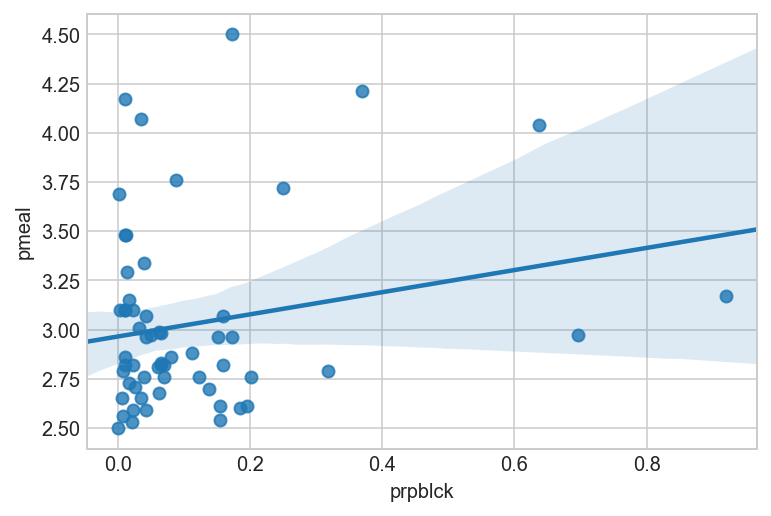

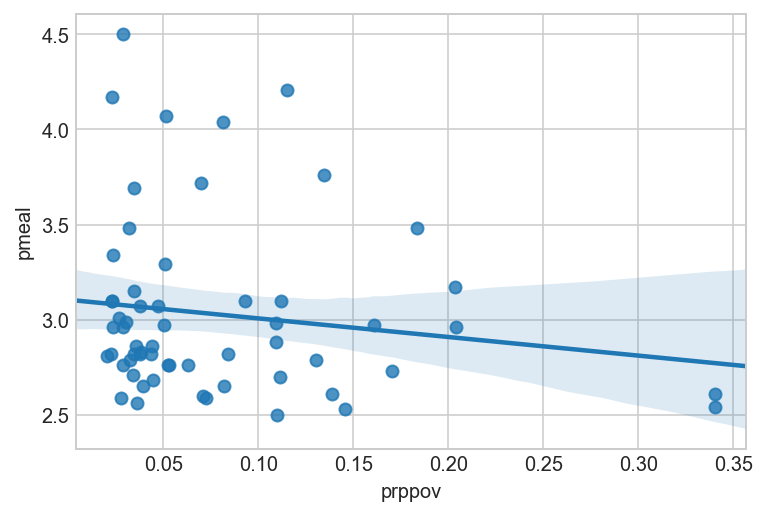

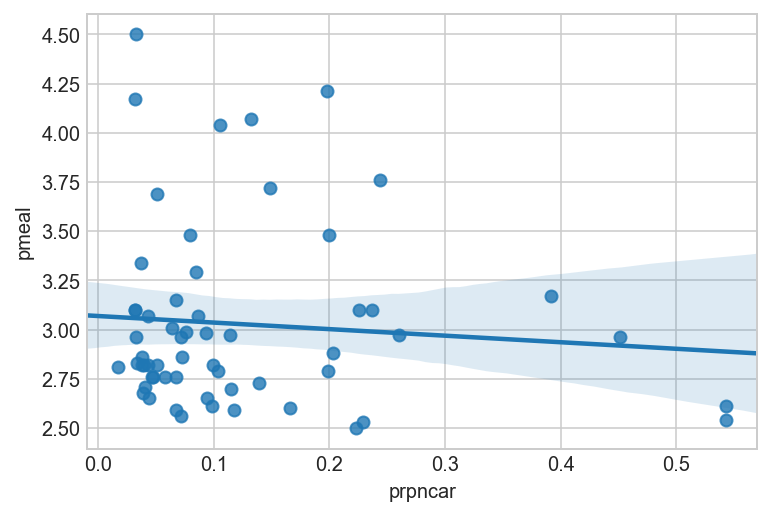

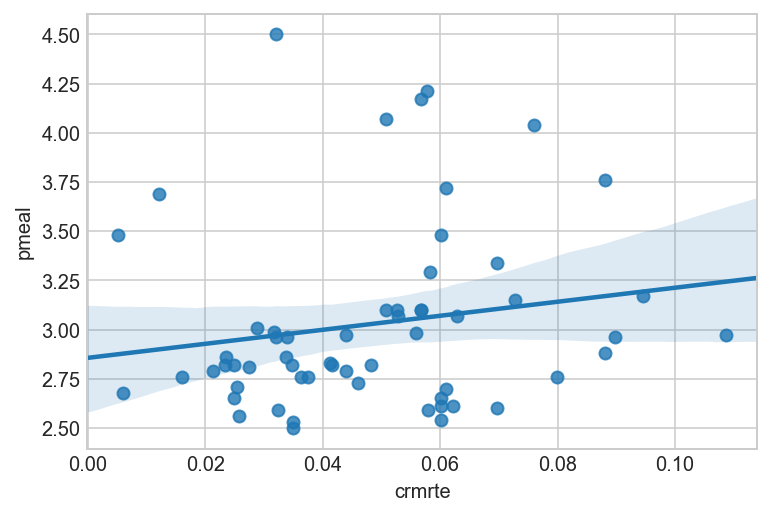

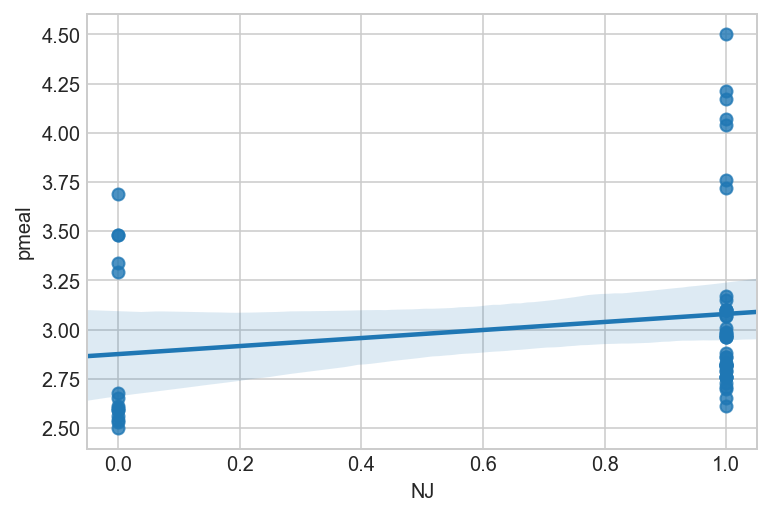

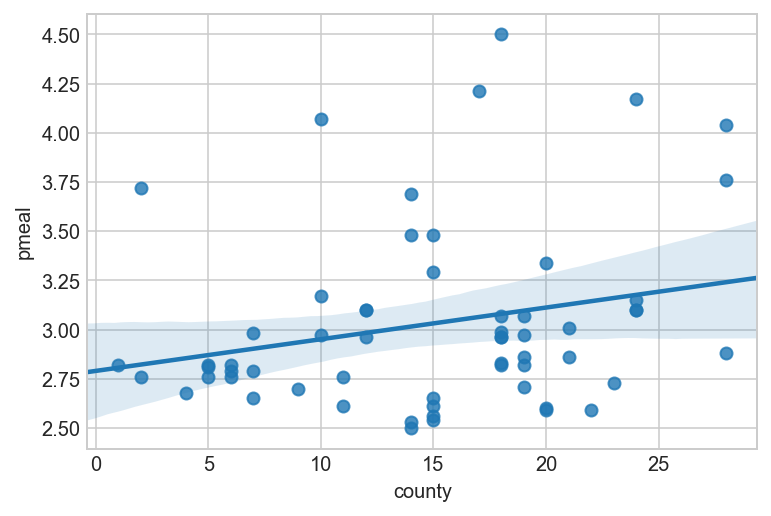

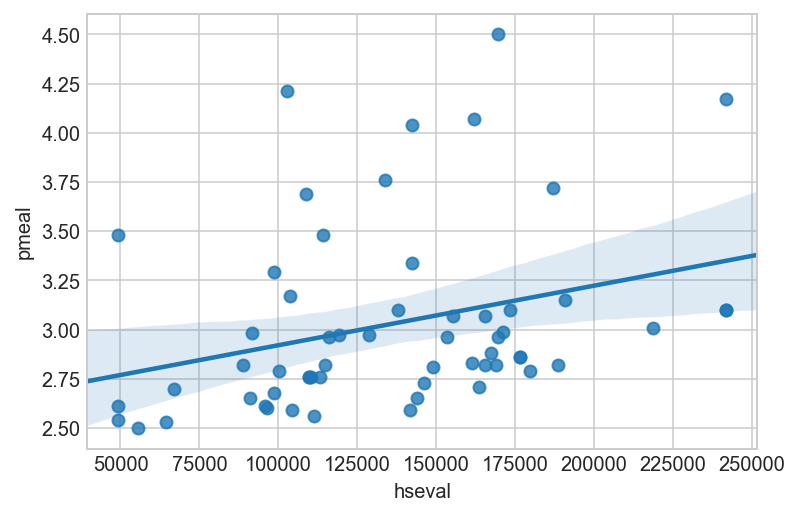

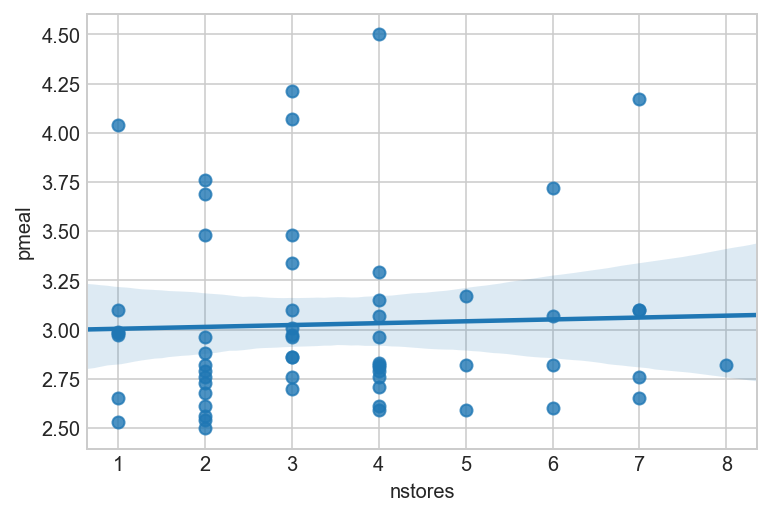

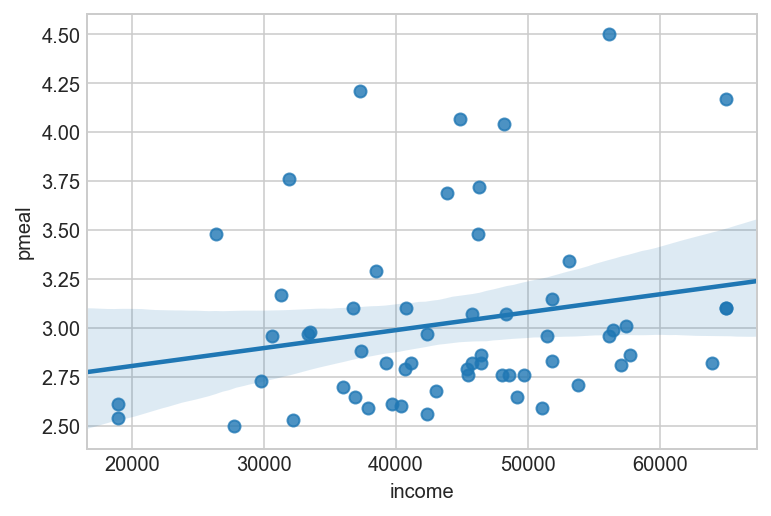

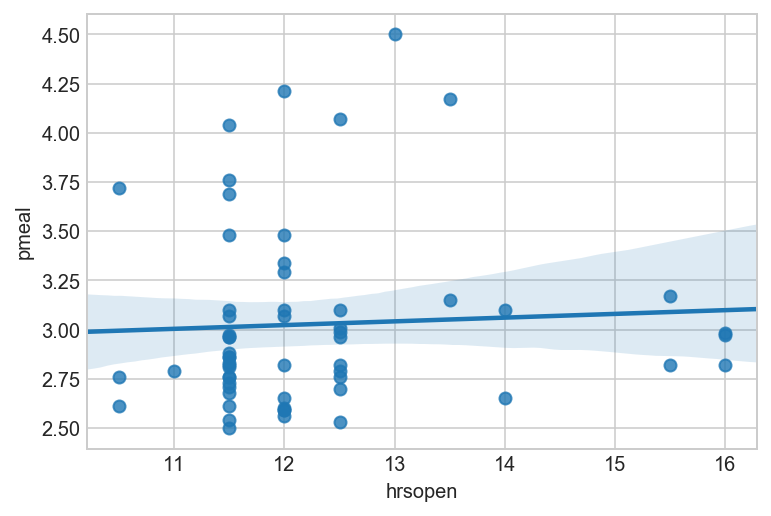

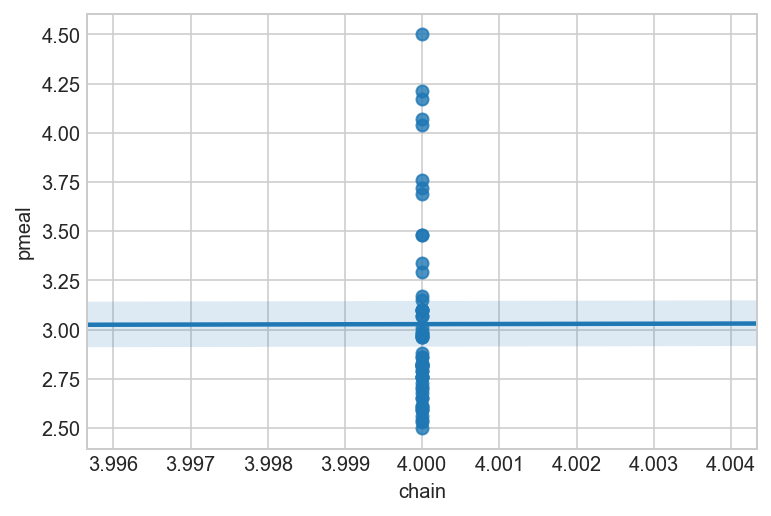

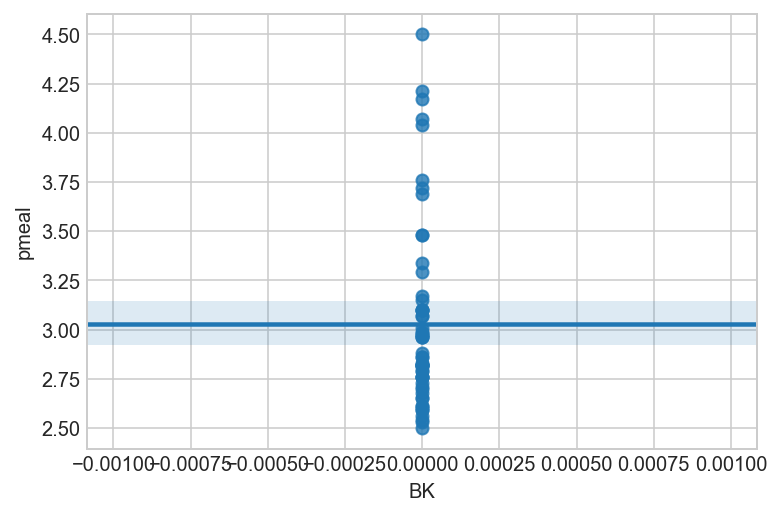

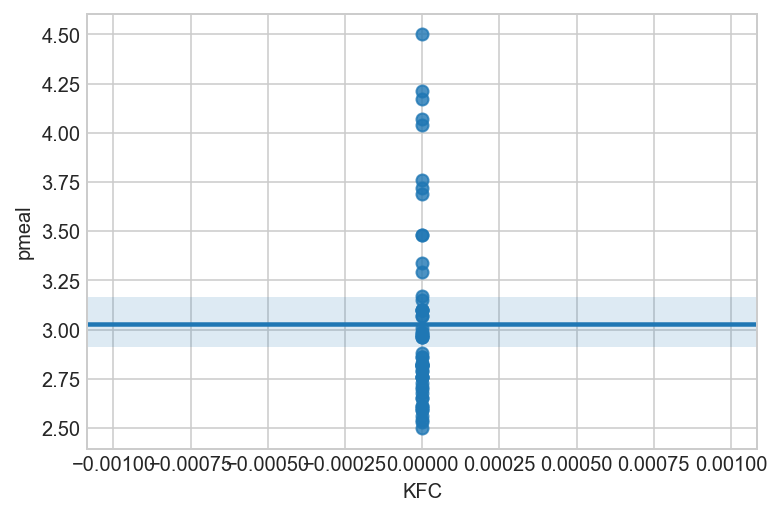

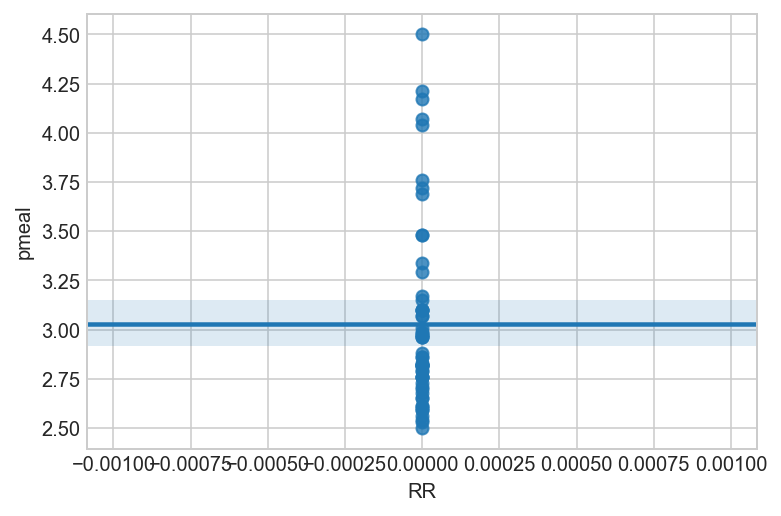

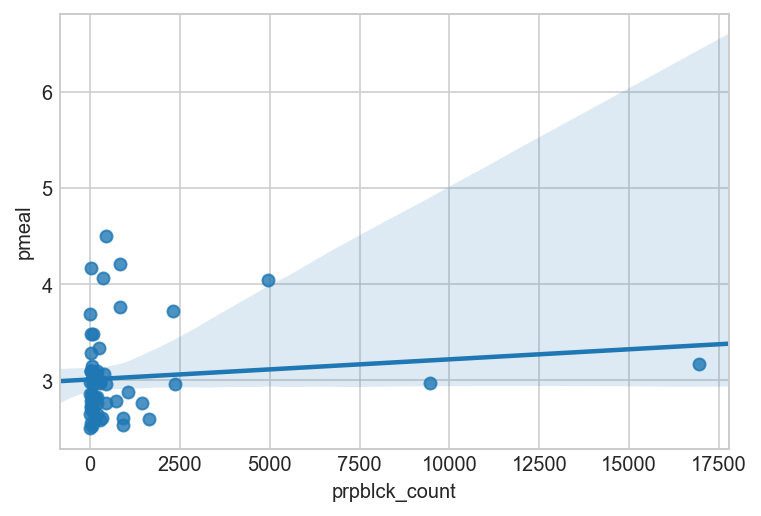

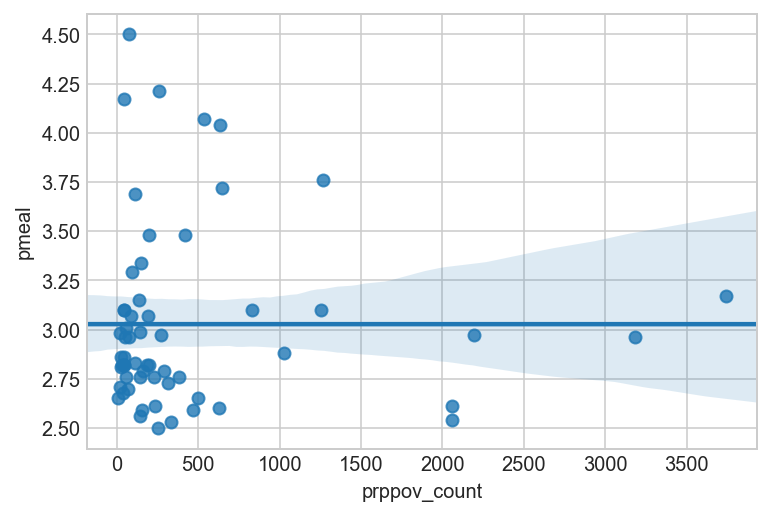

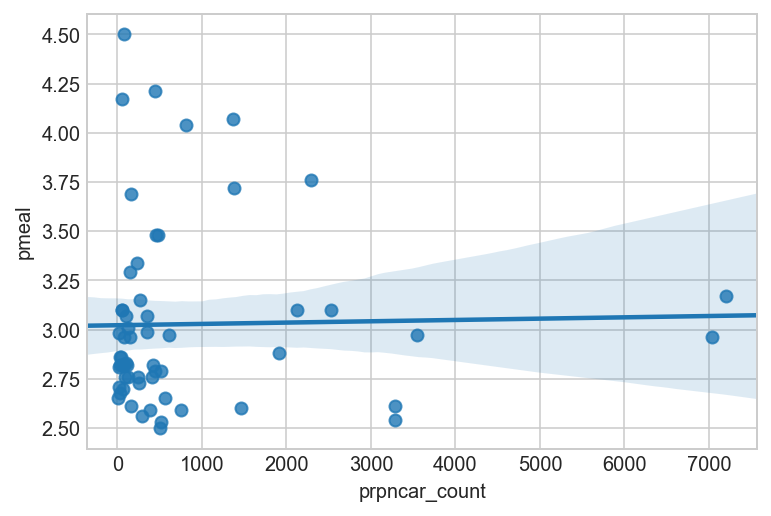

In [201]:
for i in features:
    plt.figure()
    sns.regplot(df[i],df['pmeal'])

<a id='1'> </a>
### Sucessful EDA visuals 

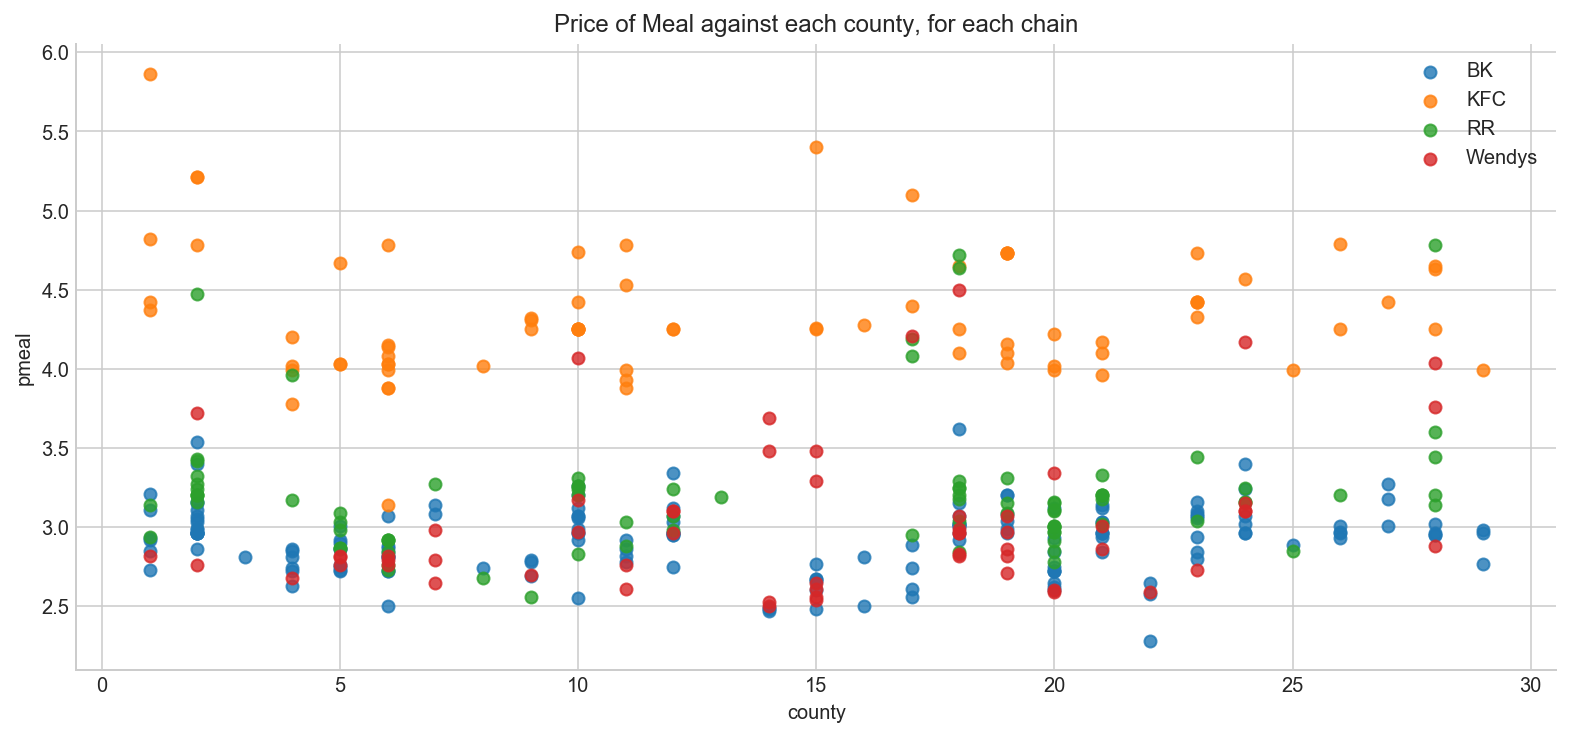

In [180]:
sns.lmplot('county','pmeal',df,hue='chain',fit_reg=False, legend = False, aspect = 2.2)
plt.title('Price of Meal against each county, for each chain')
plt.legend(['BK','KFC','RR','Wendys']);

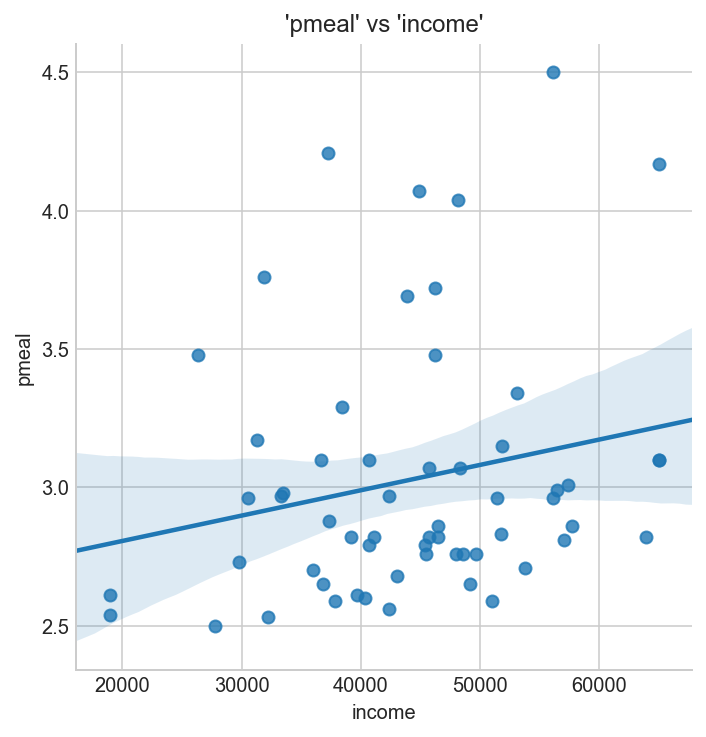

In [203]:
sns.lmplot('income','pmeal',df)
plt.title("'pmeal' vs 'income'");

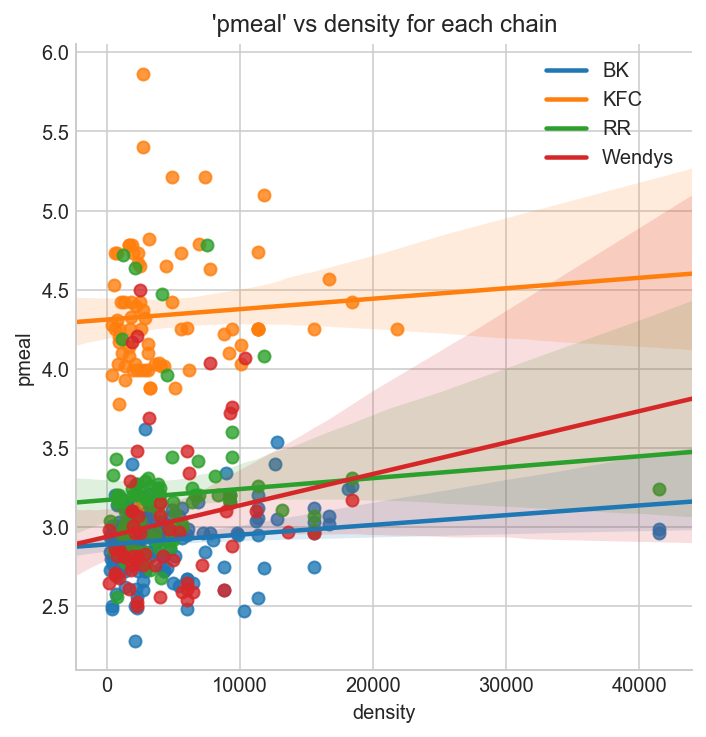

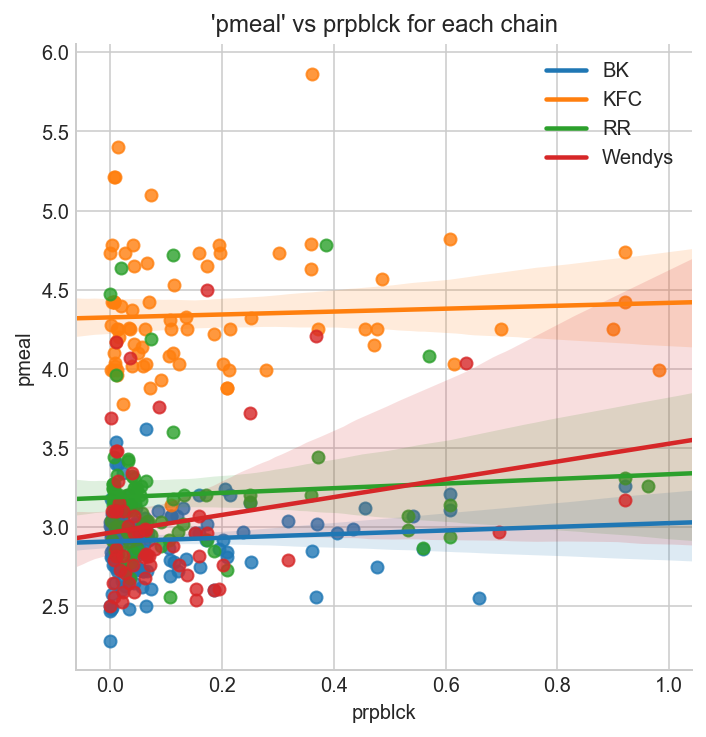

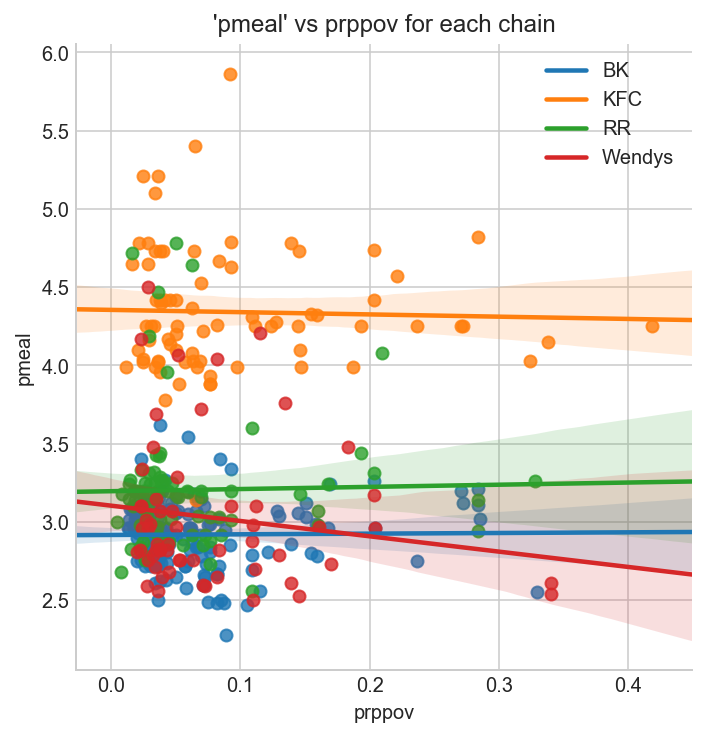

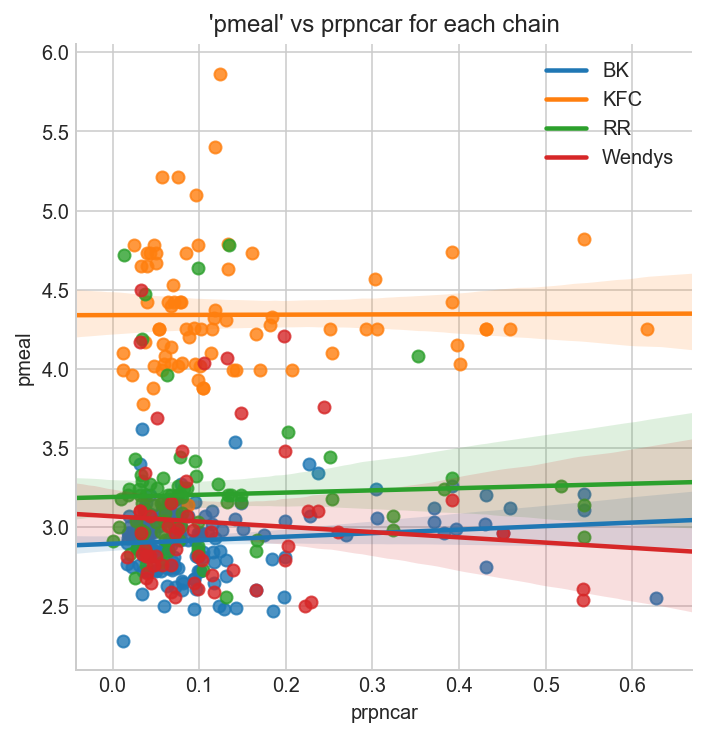

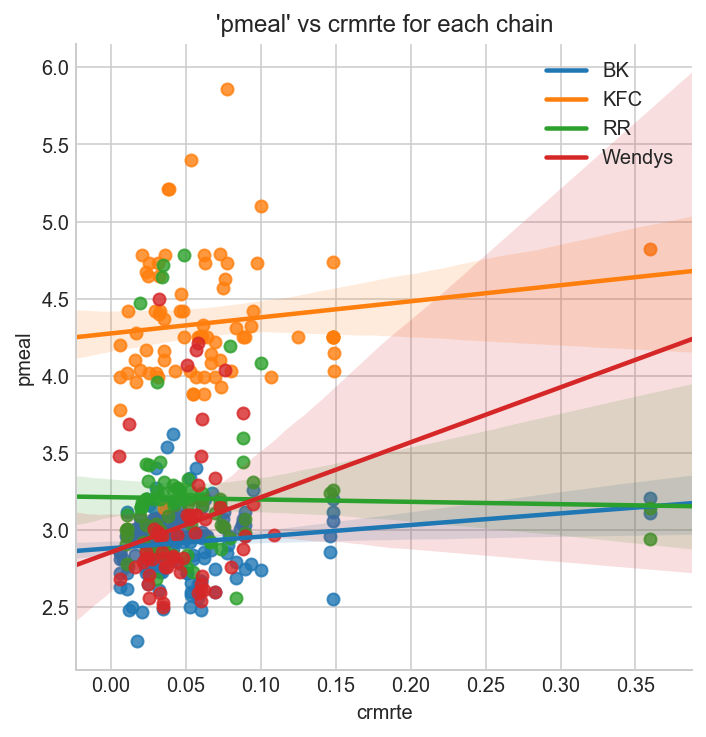

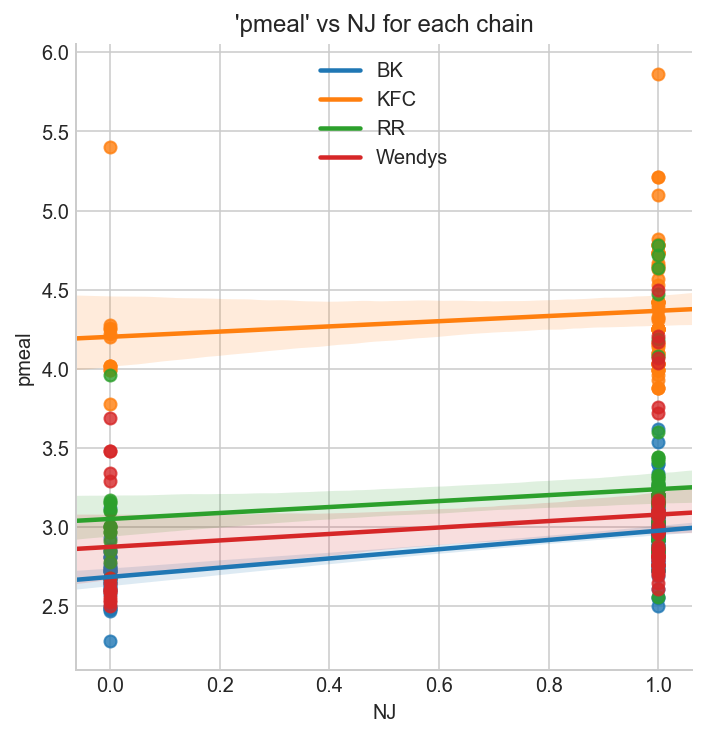

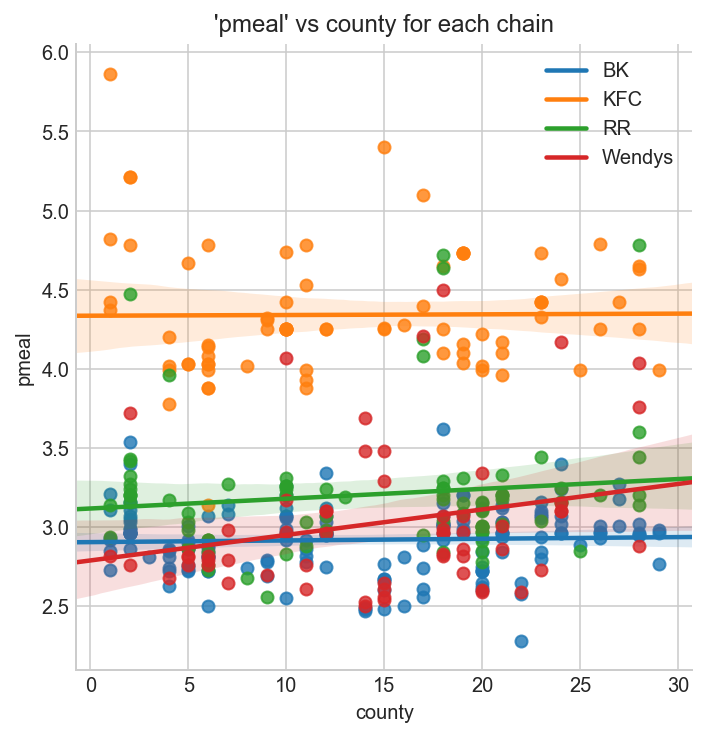

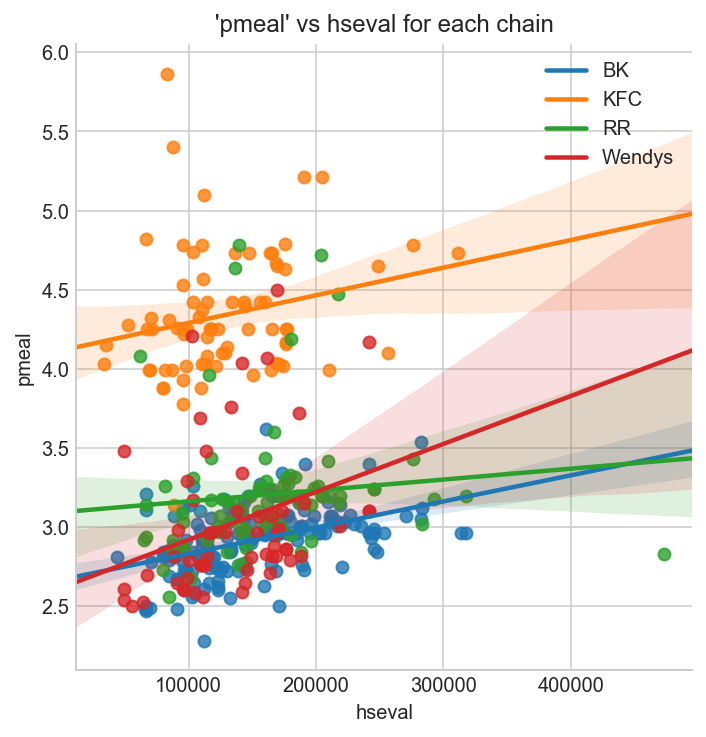

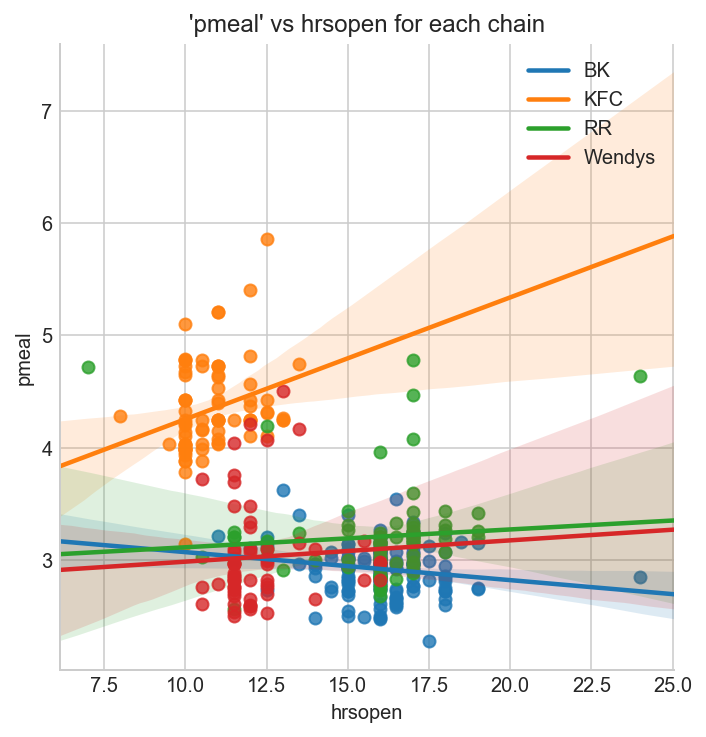

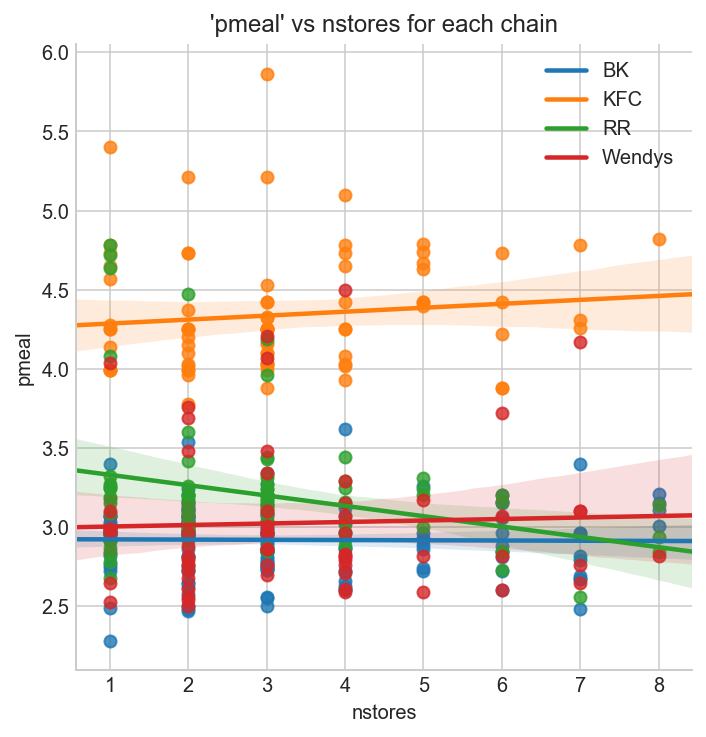

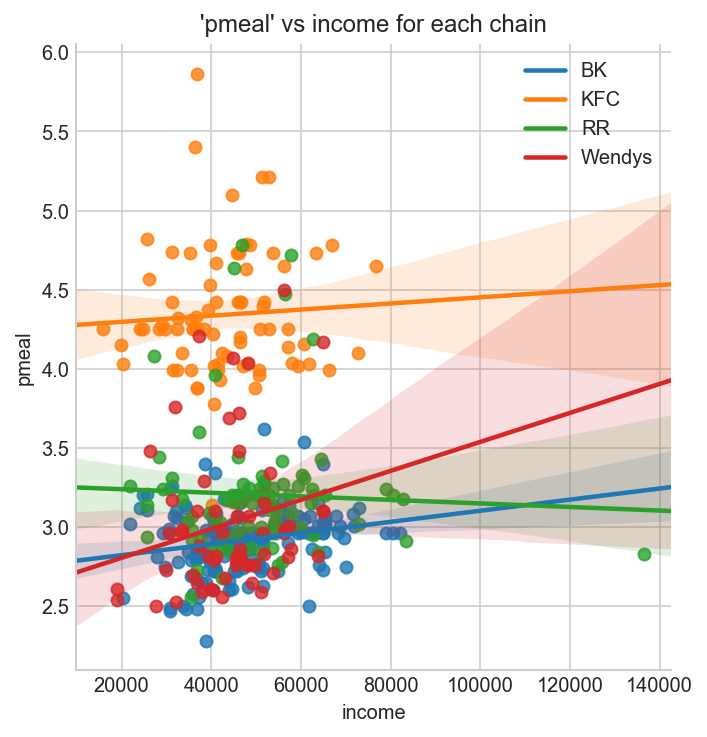

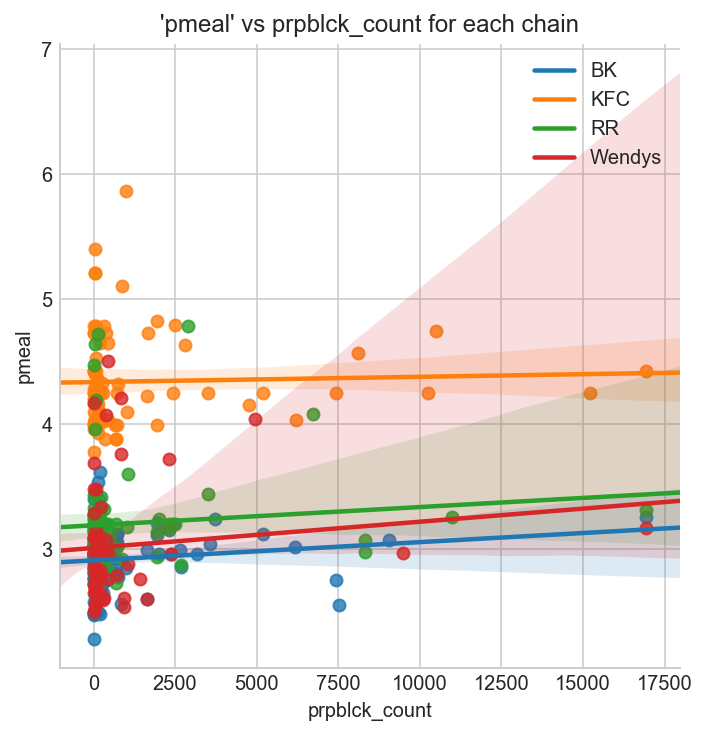

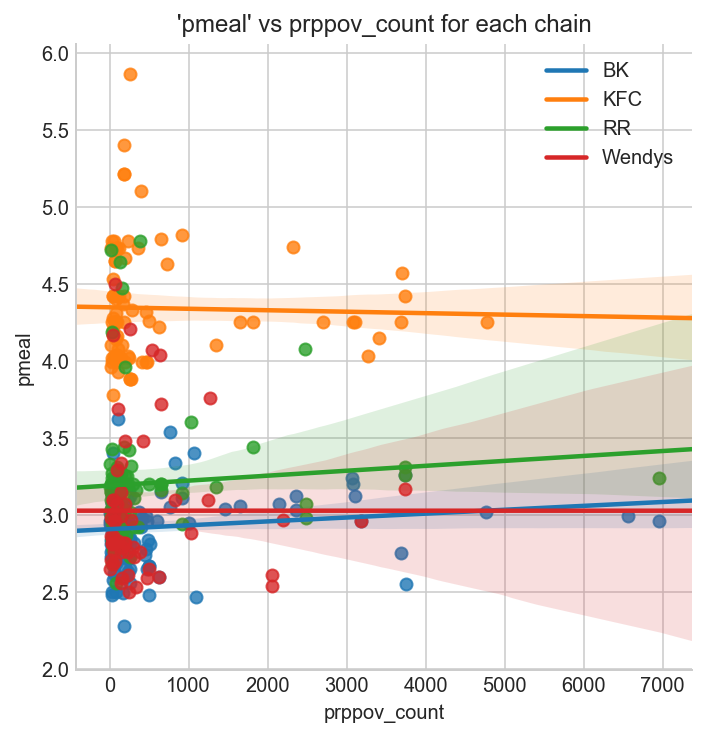

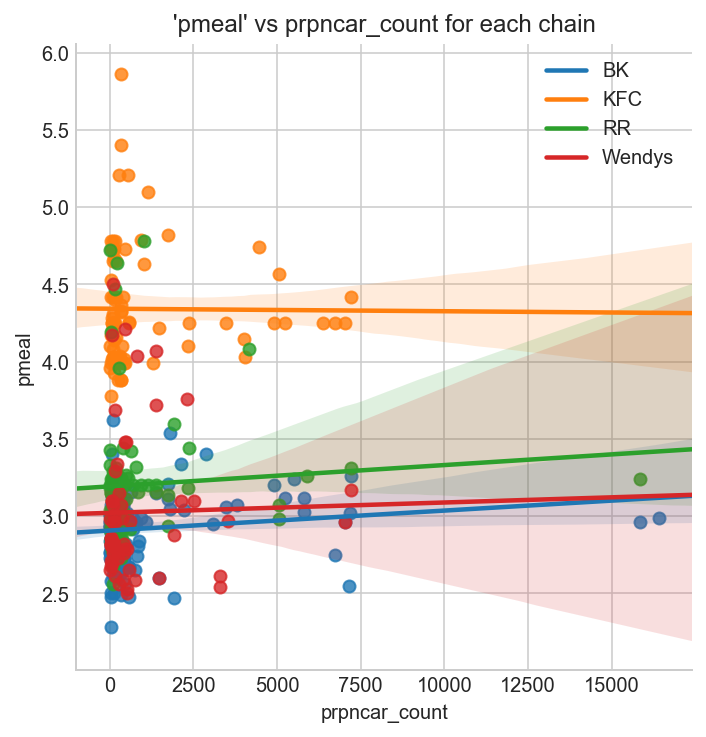

In [182]:
for trend in featuresp:
    plt.figure()
    sns.lmplot(trend,'pmeal',df,hue='chain',legend=False)
    plt.title("'pmeal' vs {} for each chain".format(trend))
    plt.legend(['BK','KFC','RR','Wendys'])


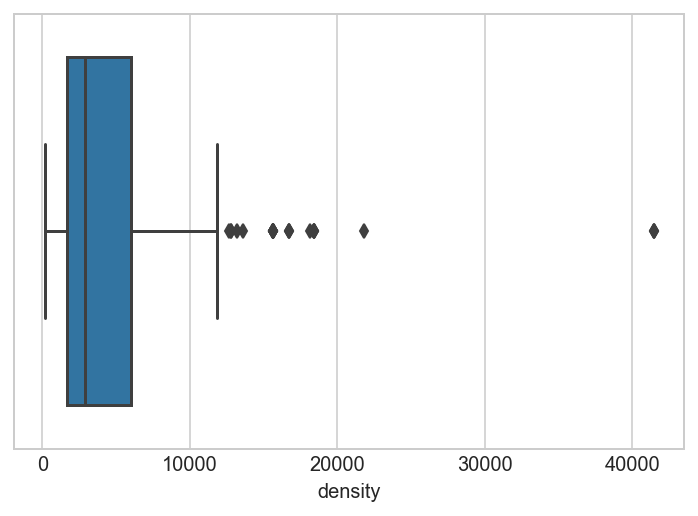

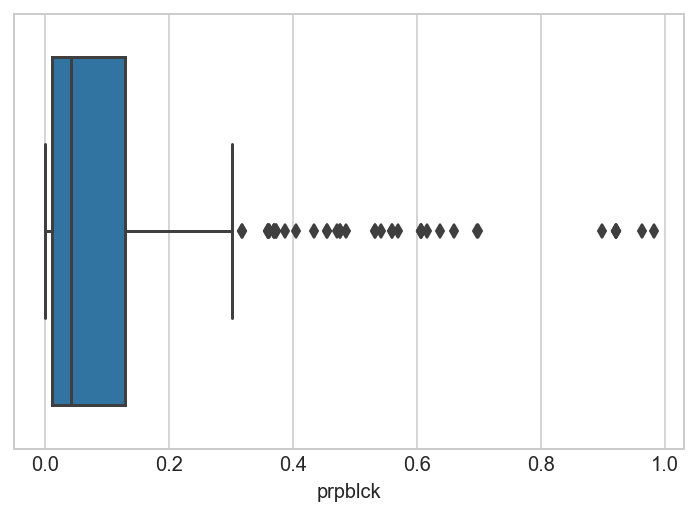

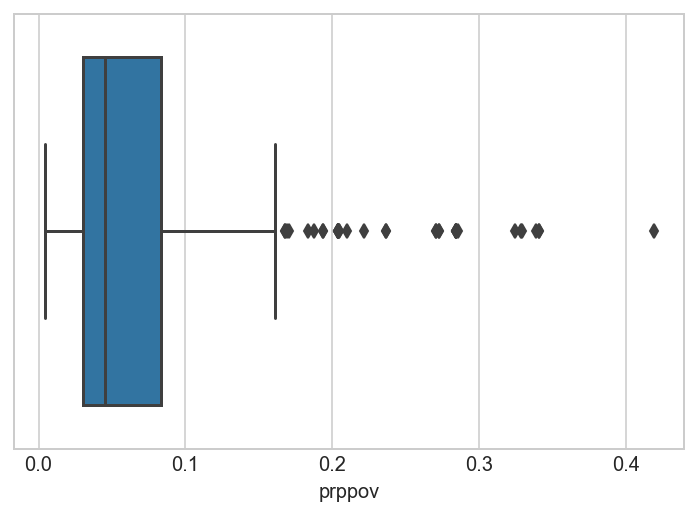

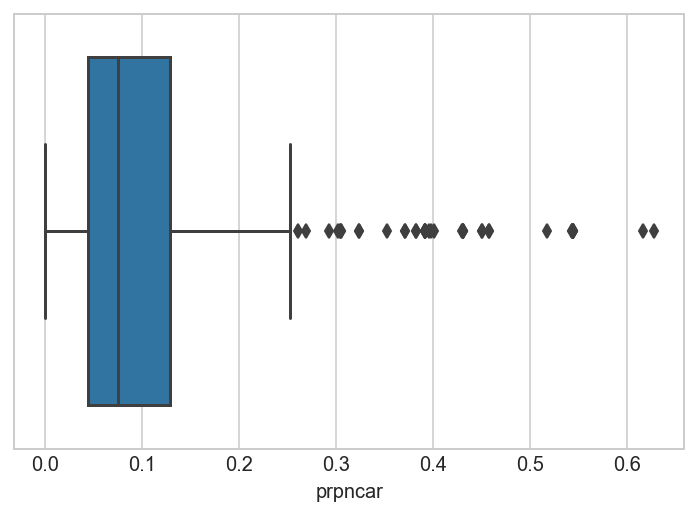

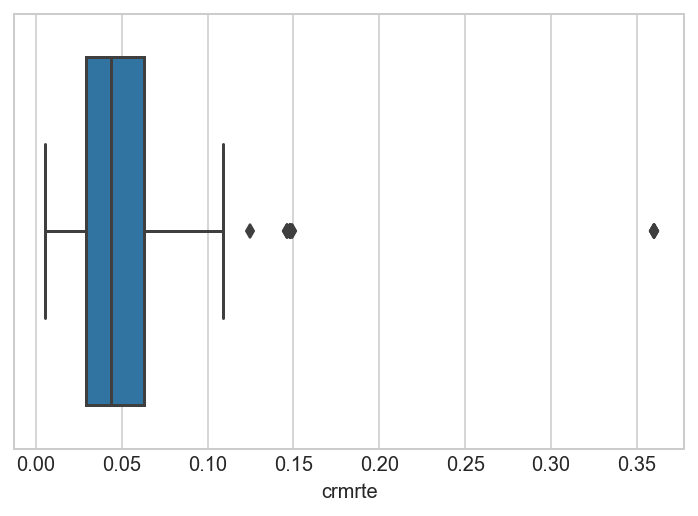

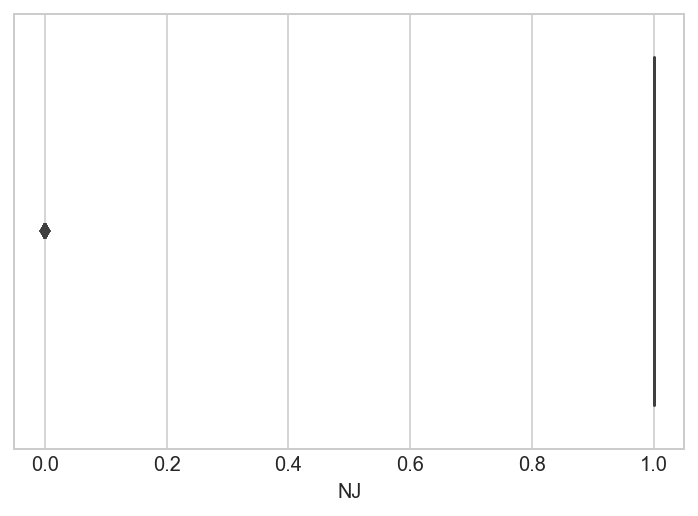

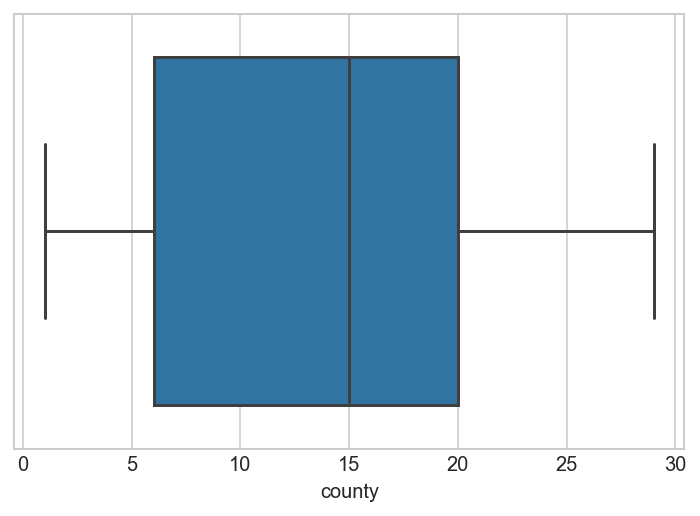

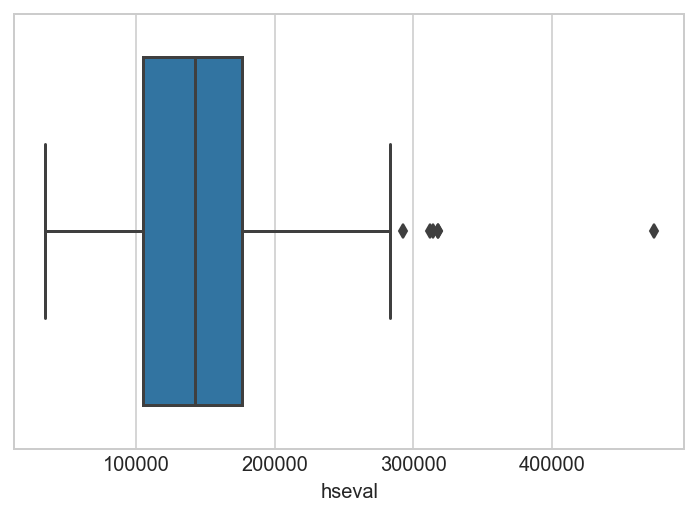

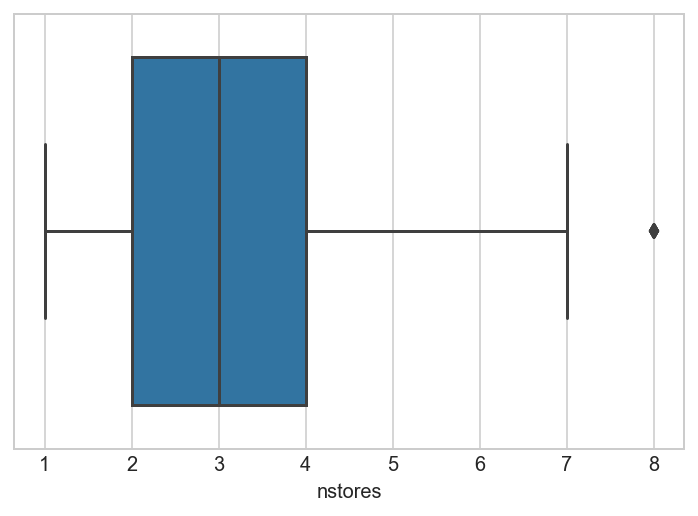

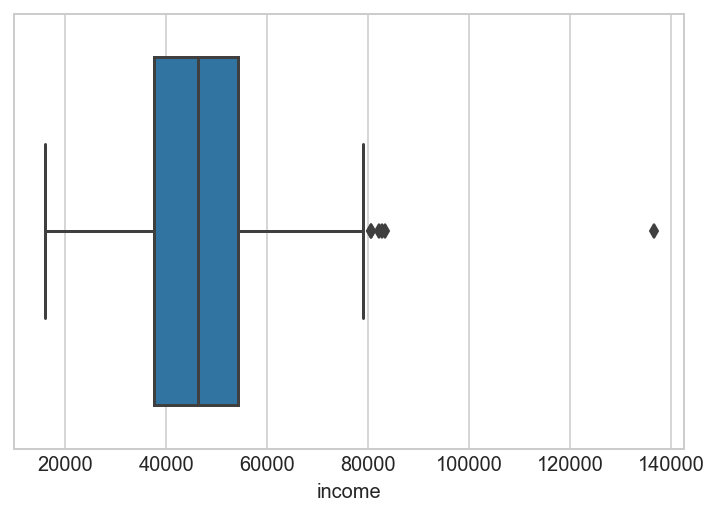

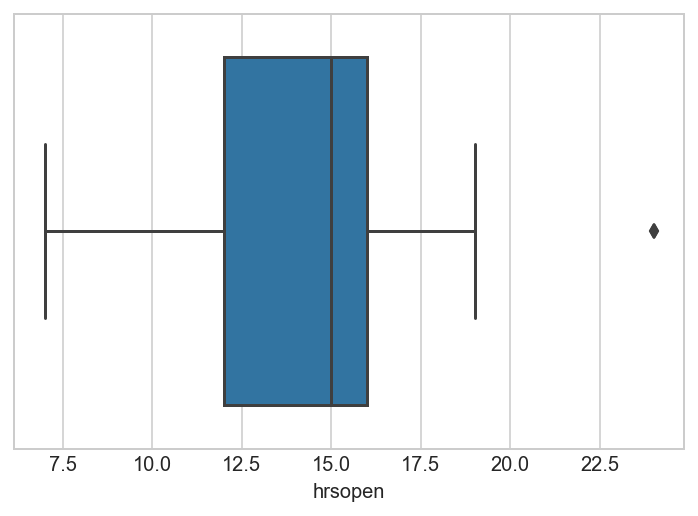

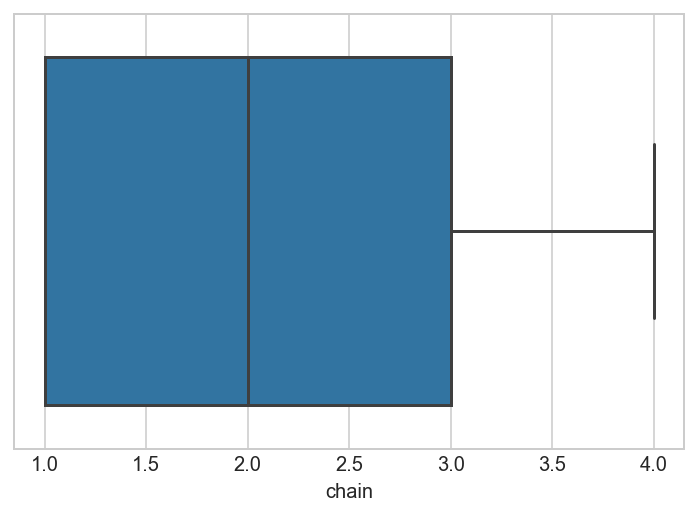

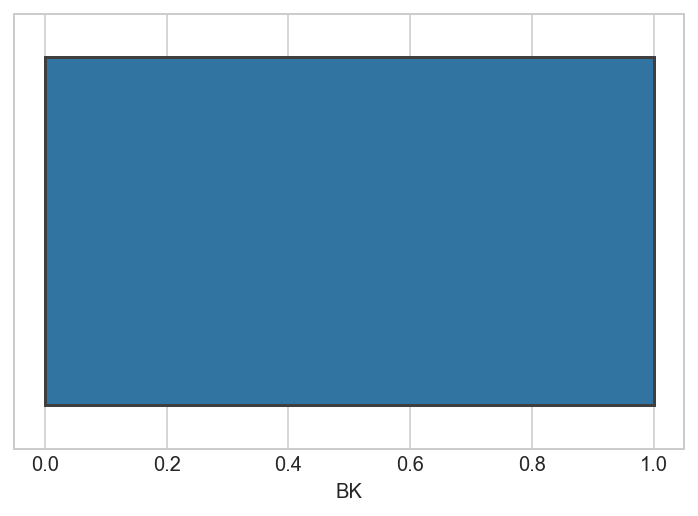

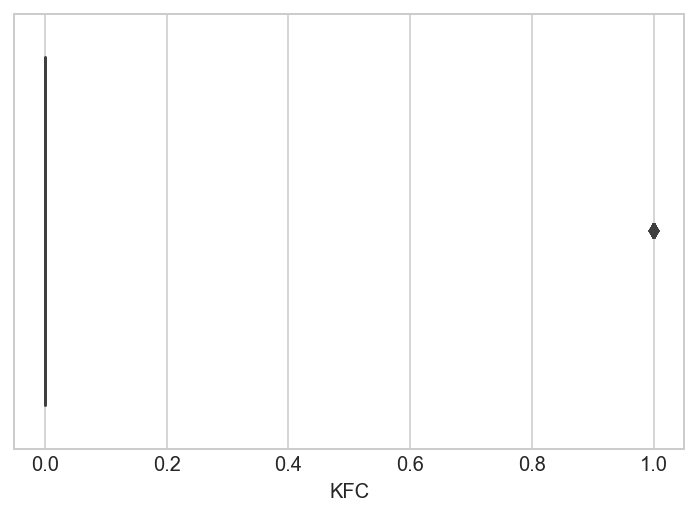

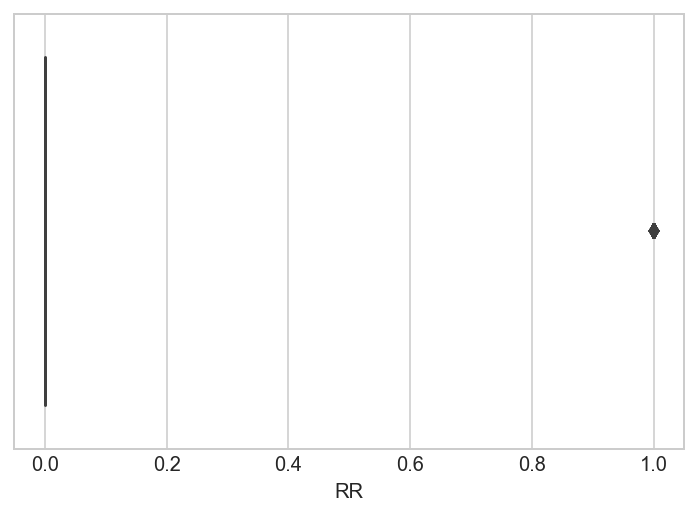

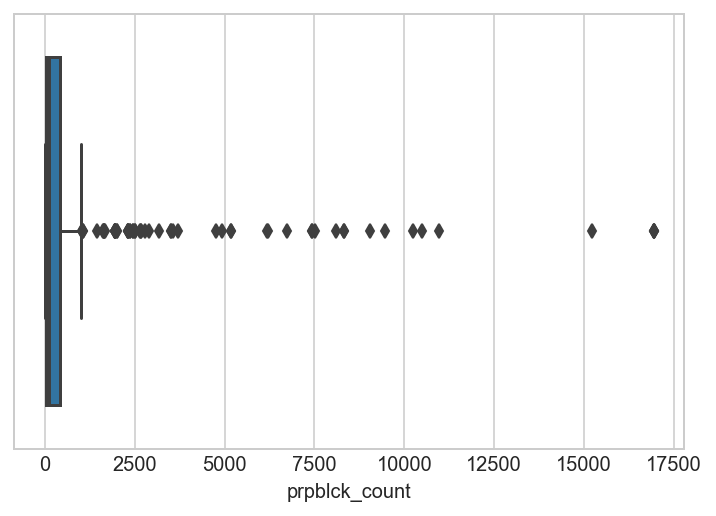

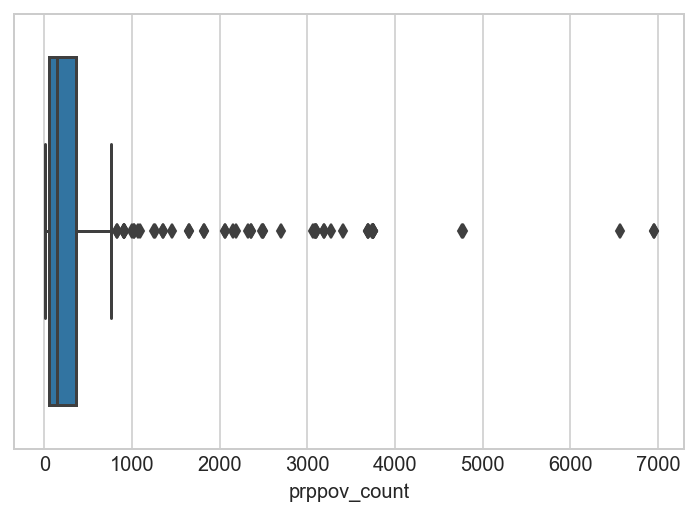

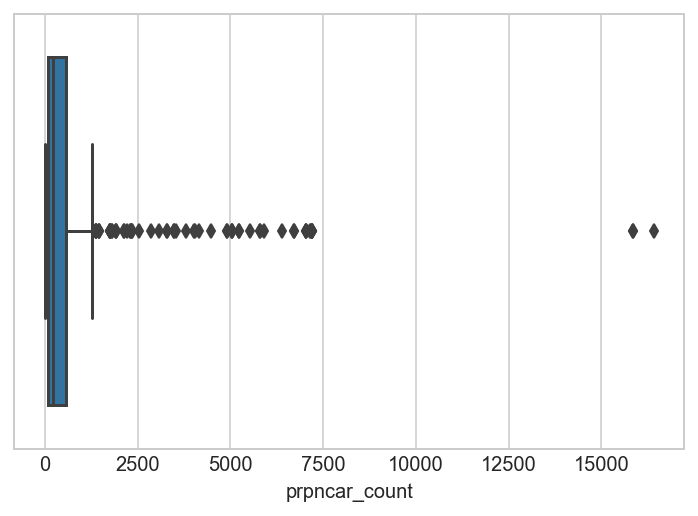

In [198]:
# Boxplot to see outlier, but there is too many outliers to drop any outliers
for i in features:
    plt.figure()
    sns.boxplot(df[i])

## T-test

In [167]:
for i in features:
    grp1 = df[df[i]<=np.median(df[i])]
    grp2 = df[df[i]>np.median(df[i])]
    print i, stats.ttest_ind(grp1['pmeal'],grp2['pmeal'])

density Ttest_indResult(statistic=-0.6171154383898729, pvalue=0.5375252726098844)
prpblck Ttest_indResult(statistic=-1.816714456026876, pvalue=0.07004234601904112)
prppov Ttest_indResult(statistic=-1.276729983845415, pvalue=0.20247113199596017)
prpncar Ttest_indResult(statistic=-2.236821279258457, pvalue=0.02587291444646984)
crmrte Ttest_indResult(statistic=-2.7214395391365933, pvalue=0.00679649134445293)
NJ Ttest_indResult(statistic=nan, pvalue=nan)
county Ttest_indResult(statistic=-0.962809341724887, pvalue=0.33625069115155537)
hseval Ttest_indResult(statistic=-0.5828671531806998, pvalue=0.5603257440701903)
nstores Ttest_indResult(statistic=-0.23465730331003223, pvalue=0.8146001270289235)
income Ttest_indResult(statistic=-0.0739165866692549, pvalue=0.9411153464230283)
hrsopen Ttest_indResult(statistic=9.242420563730057, pvalue=1.6987777540808222e-18)
chain Ttest_indResult(statistic=3.7321149404591103, pvalue=0.00021865313176462888)
BK Ttest_indResult(statistic=10.915783552249144, pva

##### hrs open was only added after presentation. pvalue is low 
hrsopen Ttest_indResult(statistic=9.242420563730057, pvalue=1.6987777540808222e-18)

In [199]:
# from EDA, we found that there is price range difference between the price. 
# Hence, we split the df by their chain
dfKFC = df[df['KFC'] == 1]
dfBK = df[df['BK'] == 1]
dfRR = df[df['RR'] == 1]
dfWD = df[df['chain'] == 4]

In [200]:
for i,df in enumerate([dfKFC,dfBK,dfRR,dfWD]):
    print '/n{}'.format(i)
    for i in features1:
        grp1 = df[df[i]<=np.median(df[i])]
        grp2 = df[df[i]>np.median(df[i])]
        print i, stats.ttest_ind(grp1['pmeal'],grp2['pmeal'])

/n0
density Ttest_indResult(statistic=-0.49354432238956153, pvalue=0.6230512935969809)
prpblck Ttest_indResult(statistic=-0.08858979521316744, pvalue=0.9296409478379043)
prppov Ttest_indResult(statistic=-0.09412728390489618, pvalue=0.925255765491551)
prpncar Ttest_indResult(statistic=-0.376838763759717, pvalue=0.7073435591517617)
crmrte Ttest_indResult(statistic=-0.5993617654187462, pvalue=0.550714290705036)
NJ Ttest_indResult(statistic=nan, pvalue=nan)
county Ttest_indResult(statistic=-0.9761336974598515, pvalue=0.3320950991001821)
hseval Ttest_indResult(statistic=-1.0144563318970912, pvalue=0.31358382354960923)
hrsopen Ttest_indResult(statistic=-2.98440271256017, pvalue=0.0038198153365320386)
nstores Ttest_indResult(statistic=-1.4078210649435532, pvalue=0.1632613163578661)
income Ttest_indResult(statistic=-0.6105149946432739, pvalue=0.5433421568480243)
prpblck_count Ttest_indResult(statistic=0.1716671395312485, pvalue=0.8641554959736332)
prppov_count Ttest_indResult(statistic=-1.7447

# line regression

In [205]:
def findregression(predictors,dataframe):
    df = dataframe
    X_train = df[predictors]
    y_train = df['pmeal']

#     X_train = df_train[predictors]
#     y_train = df_train['pmeal']

    lr = linear_model.LinearRegression()
    lr.fit(X_train,y_train)

    for f, coeff in zip(predictors,lr.coef_):
        print(f,coeff)
    print ('intercept', lr.intercept_)
    
    print 'R2score: ', lr.score(X_train,y_train)
    
    scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='r2')
    print scores
    print np.mean(scores), np.std(scores)
    
    model = sm.OLS(y_train, X_train)
    modelsm = model.fit() 
    return modelsm.summary()



In [206]:
predictors=['KFC','BK','RR','income','crmrte']
findregression(predictors,df)

('KFC', 0.0)
('BK', 1.4691581931997868e-11)
('RR', 1.7763568394002505e-15)
('income', 1.1705175704983624e-05)
('crmrte', 4.9286974384898965)
('intercept', 2.2734231336658617)
R2score:  0.09754639993951797
[ -0.03846807  -0.4429503    0.08057075  -1.89625064 -26.30963891
  -3.75792063  -0.23043708  -0.10031261  -0.72675969  -0.38096443]
-3.380313159734397 7.723925922393902


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pmeal   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     699.7
Date:                Fri, 22 Jun 2018   Prob (F-statistic):           7.75e-41
Time:                        17:46:35   Log-Likelihood:                -54.147
No. Observations:                  59   AIC:                             112.3
Df Residuals:                      57   BIC:                             116.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
KFC                 0          0        nan        nan           0           0
BK          -3.62e-11   6.39e-12     -5.668      0.000    -4.9e-11   -2.34e-11
RR                  0          0        nan        nan           0           0
income      4.854e-05   3.45e-06     14.071      0.000    4.16e-05    5.54e-05
crmrte        16.7611      2.957      5.668      0.000      10.840      22.683
==============================================================================
Omnibus:                        9.945   Durbin-Watson:                   1.355
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.987
Skew:                           0.798   Prob(JB):                      0.00678
Kurtosis:                       4.232   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# EXTRA???

In [104]:
df['BKxincome'] = df['BK']*df['income']
df.head()

,psoda,pfries,pentree,wagest,nmgrs,nregs,hrsopen,emp,compown,chain,...,county,NJ,BK,KFC,RR,pmeal,prpblck_count,prppov_count,prpncar_count,BKxincome
0,1.12,1.06,1.02,4.25,3.0,5.0,16.0,27.5,1,3,...,18,1,0,0,1,3.20,689.751426,147.412967,317.736484,0.0
1,1.06,0.91,0.95,4.75,3.0,3.0,16.5,21.5,0,1,...,18,1,1,0,0,2.92,689.751426,147.412967,317.736484,44534.0
2,1.06,0.91,0.98,4.25,3.0,5.0,18.0,30.0,0,1,...,12,1,1,0,0,2.95,539.906280,1002.142080,3071.499720,41164.0
3,1.12,1.02,1.06,5.00,4.0,5.0,16.0,27.5,0,3,...,10,1,0,0,1,3.20,440.944793,493.378932,1140.680553,0.0
5,1.06,0.95,1.01,4.25,4.0,4.0,15.0,17.5,0,1,...,18,1,1,0,0,3.02,261.603065,369.404442,509.353258,44515.0


In [106]:
predictors=['BKxincome']
findregression(predictors,df)

('BKxincome', -1.2018657732259483e-05)
('intercept', 3.536525801865906)
R2score:  0.17260805648108024


In [109]:
predictors=['KFC','RR','BK','income','crmrte']
findregression(predictors,df)

('KFC', 1.3134692917297994)
('RR', 0.15625659557615323)
('BK', -0.13653721882945688)
('income', 4.446519685635432e-06)
('crmrte', 1.5391365537317296)
('intercept', 2.763577809363438)
R2score:  0.7242069630840412
